In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import random
import seaborn as sns
import json
import decimal
import shutil
from imgaug import augmenters as iaa
import imgaug as ia
import cv2

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image as tf_image
from sklearn.utils.class_weight import compute_class_weight

2024-10-23 22:00:56.391606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 22:00:56.988854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/FCAM/ryerramsetti/striplens/pythonenv/lib/python3.8/site-packages/cv2/../../lib64:
2024-10-23 22:00:56.988905: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-23 22:01:01.242301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

In [3]:
print(os.getcwd())

/home/FCAM/ryerramsetti/striplens


In [4]:
annotation_path = os.getenv('ANNOTATION_PATH', '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/Annotation')
image_path = os.getenv('IMAGE_PATH', '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/Images')



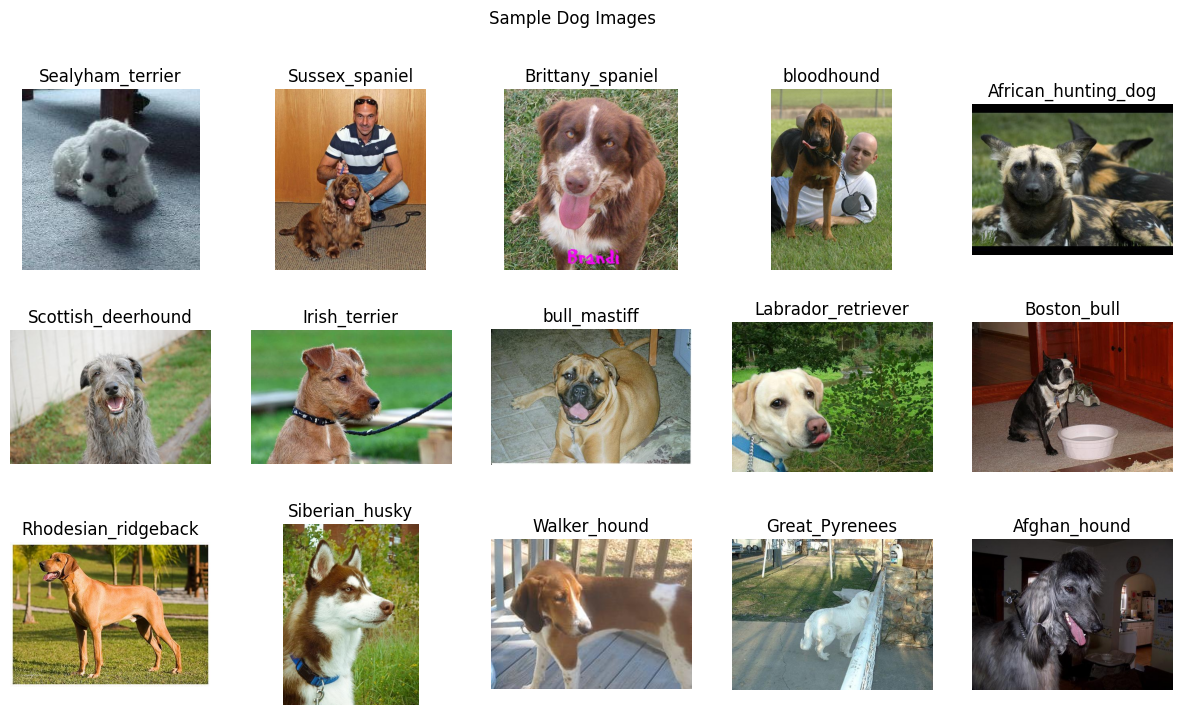

In [5]:
breed_list = os.listdir(annotation_path)
fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list)
    breed_path = os.path.join(annotation_path, breed)
    dog = np.random.choice(os.listdir(breed_path))
    img_path = os.path.join(image_path, breed, dog + '.jpg')
    img = Image.open(img_path)
    annotation_file = os.path.join(breed_path, dog)
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    object_1 = root.findall('object')[0]
    name = object_1.find('name').text
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

In [6]:
data_dir = '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)
  print(f'Created directory: {data_dir}')
else:
  print(f'Directory already exists: {data_dir}')

for breed in breed_list:
  breed_dir = os.path.join(data_dir, breed)
  if not os.path.exists(breed_dir):
    os.mkdir(breed_dir)
    print(f'Created directory: {breed_dir}')
  else:
    print(f'Directory already exists: {breed_dir}')

print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir(data_dir))))

for breed in os.listdir(data_dir):
  for file in os.listdir(os.path.join(annotation_path, breed)):
    img = Image.open(os.path.join(image_path, breed, f'{file}.jpg'))
    tree = ET.parse(os.path.join(annotation_path, breed, file))
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(os.path.join(data_dir, breed, f'{file}.jpg'))

Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02096585-Boston_bull
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02109961-Eskimo_dog
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02102973-Irish_water_spaniel
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02088364-beagle
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02111500-Great_Pyrenees
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02105641-Old_English_sheepdog
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02094114-Norfolk_terrier
Directory already exists: /home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/n02089078-black-and-tan_coonhound
Directory already exists: /ho

In [7]:
for breed in os.listdir(annotation_path):
  breed_path = os.path.join(annotation_path, breed)
  for annotation_file in os.listdir(breed_path):
    if '(' in annotation_file:
      file_path = os.path.join(breed_path, annotation_file)
      try:
        os.remove(file_path)
        print(f"Removed file: {file_path}")
      except Exception as e:
        print(f"Error removing file {file_path}: {e}")

In [10]:
original_data_dir = '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/data/'
train_data_dir = '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/train/'
test_data_dir = '/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/test/'
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        
        train_class_dir = os.path.join(train_data_dir, class_name)
        test_class_dir = os.path.join(test_data_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
       
        for image in train_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))
        
        for image in test_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(test_class_dir, image))

In [11]:
ia.seed(1)

# Data augmentation definition
seq = iaa.Sequential([
    iaa.OneOf([
        iaa.Fliplr(0.5),  # Randomly flips the image horizontally
        iaa.CropAndPad(percent=(-0.1, 0.1)),  # Cropping and adding padding
        iaa.Crop(percent=(0, 0.1)),  # Randomly crops images
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.3))),  # Occasionally adds Gaussian blur
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Scales the image
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Translates the image
            rotate=(-20, 20),  # Rotates the image
            shear=(-8, 8)  # Applies shear transformation
        )
    ])
], random_order=True)


In [12]:
class AugmentedImageDataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, image_size, seq, shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.seq = seq
        self.shuffle = shuffle
        self.class_names = sorted(os.listdir(image_dir))
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.image_paths = []
        self.labels = []
        
        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            for fname in os.listdir(class_dir):
                if fname.endswith('.jpg'):  # Filter only image files
                    self.image_paths.append(os.path.join(class_dir, fname))
                    self.labels.append(self.class_indices[class_name])
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = np.array([self.load_image(img_path) for img_path in batch_paths])
        labels = np.array(batch_labels)
        
        # Augmenting images
        images_aug = self.seq(images=images)
        
        return preprocess_input(images_aug), labels
    
    def load_image(self, img_path):
        # Loads the image and resizes it to the specified size
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.image_size, self.image_size))
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


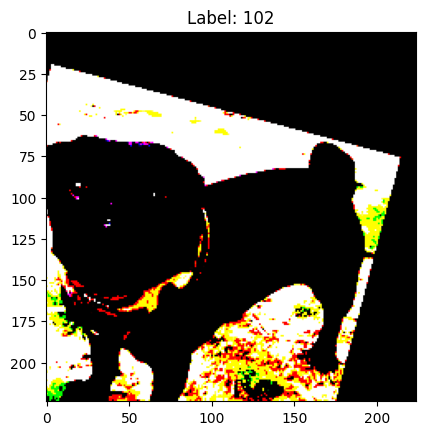

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


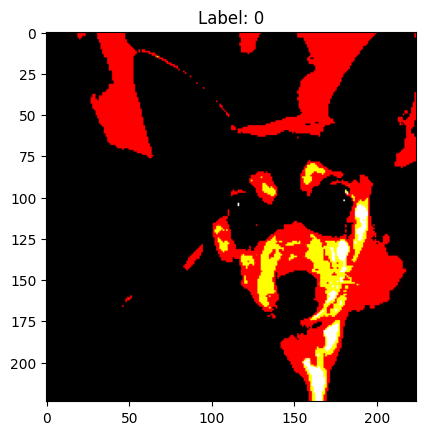

In [13]:
batch_size = 32
image_size = 224

# Data generator with data augmentation for the training set
train_generator = AugmentedImageDataGenerator(
    image_dir=train_data_dir,
    batch_size=batch_size,
    image_size=image_size,
    seq=seq,  # Augmentation using imgaug
    shuffle=True
)

# Data generator for the test set (without augmentation)
test_generator = AugmentedImageDataGenerator(
    image_dir=test_data_dir,
    batch_size=batch_size,
    image_size=image_size,
    seq=iaa.Noop(), # No augmentation
    shuffle=False 
)

# Callback to save the best model (when val_acc increases)
checkpoint = ModelCheckpoint(
    'dog_breed_classifier_model.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max', 
    save_weights_only=True
)

# Callback to reduce learning rate when val_loss does not improve
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 0.2
    patience=1,
    verbose=1,
    mode='min',
    min_delta=0.0001, # Minimum change to qualify as an improvement
    cooldown=2, # Cooldown period (how many epochs to wait after reducing)
    min_lr=1e-7
)

# Callback for early stopping if val_loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5, 
    verbose=1 
)

# Sanity check
images, labels = next(iter(train_generator))
for i in range(2):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

In [14]:
class_names = []
class_counts = []

for class_folder in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_folder)
    if os.path.isdir(class_path):  
        num_images = len(os.listdir(class_path))  
        class_names.append(class_folder)  
        class_counts.append(num_images)  

# Number of classes
num_classes = len(class_names)

# Vector of class labels
class_indices = np.arange(num_classes)

# Calculate class weights
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=np.repeat(class_indices, class_counts)  # Repeat labels based on counts
)

# Create a dictionary of class weights
class_weight_dict = dict(zip(class_indices, class_weight))

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freezing ResNet layers
for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(120, activation='softmax')(x)  # 120 class for each breed

model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-10-19 09:40:08.674534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/FCAM/ryerramsetti/striplens/pythonenv/lib/python3.8/site-packages/cv2/../../lib64:
2024-10-19 09:40:08.674582: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-19 09:40:08.674624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hpc-ext-2.cam.uchc.edu): /proc/driver/nvidia/version does not exist
2024-10-19 09:40:08.674914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Te

In [14]:
train_history = model.fit(
    train_generator,
    validation_data=test_generator, 
    epochs=20,
    steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict
    
)


Epoch 1/20
513/513 [==============================] - 667s 1s/step - loss: 2.2540 - accuracy: 0.4102 - val_loss: 1.1376 - val_accuracy: 0.6382
Epoch 2/20
513/513 [==============================] - 684s 1s/step - loss: 1.3460 - accuracy: 0.5950 - val_loss: 0.9917 - val_accuracy: 0.6832
Epoch 3/20
513/513 [==============================] - 668s 1s/step - loss: 1.0750 - accuracy: 0.6690 - val_loss: 0.9611 - val_accuracy: 0.6998
Epoch 5/20
513/513 [==============================] - 670s 1s/step - loss: 1.0071 - accuracy: 0.6887 - val_loss: 0.9079 - val_accuracy: 0.7185
Epoch 6/20
513/513 [==============================] - 673s 1s/step - loss: 0.9536 - accuracy: 0.7037 - val_loss: 0.9334 - val_accuracy: 0.7137
Epoch 7/20
513/513 [==============================] - 669s 1s/step - loss: 0.9235 - accuracy: 0.7133 - val_loss: 0.8944 - val_accuracy: 0.7334
Epoch 8/20
513/513 [==============================] - 673s 1s/step - loss: 0.8705 - accuracy: 0.7271 - val_loss: 0.8591 - val_accuracy: 0.7334

In [15]:
for layer in model.layers[-30:]:
    layer.trainable = True

# Training
tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/20
513/513 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7954
Epoch 1: val_accuracy improved from -inf to 0.74615, saving model to dog_breed_classifier_model.weights.h5
513/513 [==============================] - 674s 1s/step - loss: 0.6575 - accuracy: 0.7954 - val_loss: 0.9260 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 2/20
513/513 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.8002
Epoch 2: val_accuracy did not improve from 0.74615

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
513/513 [==============================] - 672s 1s/step - loss: 0.6523 - accuracy: 0.8002 - val_loss: 0.9618 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 3/20
513/513 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.8533
Epoch 3: val_accuracy improved from 0.74615 to 0.76418, saving model to dog_breed_classifier_model.weights.h5
513/513 [==============================] - 687s 1s/step - loss: 0.4644 - acc

In [16]:
model.save('home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/dog_breed_classifier_model.h5')

In [15]:
Model_main = tf.keras.models.load_model('home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/dog_breed_classifier_model.h5')


In [16]:
test_loss, test_acc = Model_main.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

130/130 [==============================] - 159s 1s/step - loss: 0.8530 - accuracy: 0.7788
Test accuracy: 0.7788461446762085


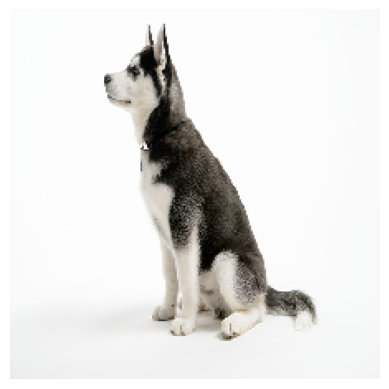

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


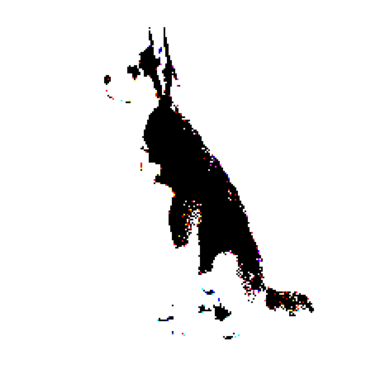

In [20]:
img_path = "/home/FCAM/ryerramsetti/Capstone_project/Dog1.jpg"
img = tf_image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

# Preparing for prediction
img_array = tf_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

In [17]:
class_indices = train_generator.class_indices
print(class_indices)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

In [21]:
class_indices = train_generator.class_indices

# Reverse the class index mapping to obtain an inverse mapping: index -> breed name
labels = dict((v, k) for k, v in class_indices.items())

# Prediction
predictions = Model_main.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Print the predicted dog breed
predicted_class_label = labels[predicted_class_index[0]]
print("Predicted dog breed:", predicted_class_label)

# Top 3 predictions
for i in np.argsort(predictions[0])[-3:][::-1]:
    predicted_class_label = labels[i]  # Class name
    probability = predictions[0][i] * 100  # Probability in %
    print(f"{probability:.2f}% \t {predicted_class_label}")

1/1 [==============================] - 1s 1s/step
Predicted dog breed: n02110185-Siberian_husky
84.73% 	 n02110185-Siberian_husky
15.25% 	 n02109961-Eskimo_dog
0.02% 	 n02110063-malamute


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load the pre-trained model
model = load_model('/home/FCAM/ryerramsetti/striplens/home/FCAM/ryerramsetti/Capstone_project/ImageNetDogs/dog_breed_classifier_model.h5')

# Set image size for your model (match the input size of your model)
img_width, img_height = 224, 224
def predict_breed(img_path):
  # Load the image
  img = load_img(img_path, target_size=(img_width, img_height))

  # Convert the image to an array
  

In [7]:
predict_breed('/home/FCAM/ryerramsetti/Capstone_project/Dog1.jpg')

1/1 [==============================] - 1s 1s/step


AttributeError: 'Functional' object has no attribute 'predict_classes'